In [ ]:
import os
import urllib.request
import requests
import shutil
import pandas as pd
import torch
import torch.nn as nn

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#import features from google drive
# List files in the current directory
files = os.listdir('/content/drive/My Drive/ExpertAdvice')
print(files)
googleDriveFolderPath = "/content/drive/My Drive/ExpertAdvice"

['cloud.data', 'spambase', 'cloudDataset.csv', 'spambaseDataset.csv', 'expertAdviceFeature Extraction.ipynb', 'normalisedCloudDataset.csv', 'normalisedSpambaseDataset.csv', 'expertAdviceNormalisation.ipynb', 'ExpertAdviceModel.ipynb']


In [ ]:
dataset = pd.read_csv(googleDriveFolderPath+"/normalisedSpambaseDataset.csv")

In [ ]:
#import dataset
feature_size = dataset.shape[1] - 1
numberOfExperts = 6
print(feature_size)

57


In [ ]:
tensor_data = torch.tensor(dataset.values)
shuffled_tensor_data = tensor_data[torch.randperm(tensor_data.size(0))]
print("Shape of shuffled tensor:", shuffled_tensor_data.shape)

Shape of shuffled tensor: torch.Size([4601, 58])


In [ ]:
# debugging cell
shuffled_tensor_data

tensor([[-3.4240e-01, -1.6505e-01,  8.4493e+00,  ..., -2.6257e-01,
         -4.5566e-01,  0.0000e+00],
        [-3.4240e-01,  1.3161e-02,  3.7575e-01,  ..., -1.6508e-01,
         -1.7365e-01,  1.0000e+00],
        [-3.4240e-01, -1.6505e-01, -1.4000e-01,  ..., -6.7590e-02,
          1.5785e-01,  1.0000e+00],
        ...,
        [-3.4240e-01,  5.4127e-03, -1.2017e-01,  ..., -1.2916e-01,
         -1.2087e-01,  0.0000e+00],
        [-3.4240e-01, -1.6505e-01, -5.5658e-01,  ..., -1.9074e-01,
         -3.6660e-01,  0.0000e+00],
        [-3.4240e-01,  1.5263e-01, -1.5984e-01,  ..., -1.9074e-01,
         -1.7859e-01,  1.0000e+00]], dtype=torch.float64)

In [ ]:
'''
define a class for representing expert
variable:
  weight vector(feature size)
  bias scalar value
methods:
  predict(input datapoint) - makes prediction with weight vector * datapoint vector + bias
  calculate_loss(prediction, label) - calculates loss using log likelhood method
  update_weights(prediction, label) - checked if prediction is not same as label, then update weight = prev weight value +  misclassified datapoint
'''

class Expert:
    def __init__(self, feature_size):
        self.weights = torch.randn(feature_size).to(torch.float32)  # Initialize weights with random values
        self.bias = torch.randn(1).to(torch.float32)             # Initialize bias with random value

    def predictLabel(self, features):
        features = features.float()
        # Make prediction using the dot product of weights and datapoint features, plus bias
        return torch.sigmoid(torch.dot(self.weights, features) + self.bias)

    def calculate_loss(self, prediction, label):
        # Calculate loss using log likelihood method
        # Instantiate the BCELoss criterion
        criterion = nn.BCELoss()
        loss = criterion(prediction, label)
        return loss

    def update_weights(self, prediction, label, features, threshold=0.5):
        predicted_label = 1 if prediction >= threshold else -1
        if label == 0:
          label = -1
        if (predicted_label * label) <= 0:
            self.weights += features * label
            self.bias += label  # Update bias with label




In [ ]:
# Create instances of the Expert class
experts = []

for _ in range(numberOfExperts):
    expert_instance = Expert(feature_size)
    experts.append(expert_instance)

In [ ]:
# Initialize learner parameters
expertLoss = torch.zeros(numberOfExperts, dtype=torch.float32)
expertPrediction = torch.zeros(numberOfExperts, dtype=torch.float32)
expertProb = torch.tensor([1/numberOfExperts] * numberOfExperts, dtype=torch.float32)
cumLossExperts = torch.zeros(numberOfExperts, dtype=torch.float32)
cumLossAlgo = torch.tensor(0.0, dtype=torch.float32)
static = 0
alpha = 0.1

In [ ]:
'''
Learner update_expert_probabilites method
input - expert loss functions, expert_probabilties
function := expert_probabilties =  expert_probabilitie * e^(-loss)
'''


def update_expert_probabilities(expertLoss, expertProb, static = 1, alpha = 0):
    if static == 1:
      #print("Static Expert Model prediction")
      # Compute the update
      updated_probs = expertProb * torch.exp(-1 * expertLoss)

      # Normalize the probabilities
      normalized_probs = nn.functional.softmax(updated_probs, dim=0)

      sum_prob = torch.sum(normalized_probs)
      if not torch.allclose(sum_prob, torch.tensor(1.0)):
          raise ValueError("The sum of updated expert probabilities is not equal to 1.")
      else:
        return normalized_probs
    else:
      #print("Fixed-alpha model prediction")
      num_experts = len(expertProb)
      updated_probs = torch.zeros_like(expertProb)

      for i in range(num_experts):
          p_i_given_j = torch.where(torch.arange(num_experts) == i, 1 - alpha, alpha / (num_experts - 1))
          updated_probs[i] = torch.sum(expertProb * torch.exp(-expertLoss) * p_i_given_j)

      normalized_probs = nn.functional.softmax(updated_probs, dim=0)
      return normalized_probs




In [ ]:
'''
learner function
aggregate_predictions(expertProb, expertPrediction)
where expertPrediction = torch.zeros(numberOfExperts, dtype=torch.float32)
expertProb = torch.tensor([1/numberOfExperts] * numberOfExperts, dtype=torch.float32) intialised already and passed on with some values

return sum(expertProb[i]*expertPrediction)

'''

def aggregate_predictions(expertProb, expertPrediction):
    # Ensure expertProb and expertPrediction have the same size
    assert len(expertProb) == len(expertPrediction)

    # Calculate the weighted sum of expert predictions
    aggregated_prediction = torch.sum(expertProb * expertPrediction)

    # Apply sigmoid function to ensure the output is between 0 and 1
    aggregated_prediction = torch.sigmoid(aggregated_prediction)

    return aggregated_prediction

In [ ]:
print(expertProb)

tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])


In [ ]:
'''
define function for gettign algorithm loss using obtained aggregated prediction and label

use same loss function as experts
# Calculate loss using log likelihood method
        loss = - (label * torch.log(prediction) + (1 - label) * torch.log(1 - prediction))
        return loss
'''
def calculate_algorithm_loss(aggregated_prediction, label):
    # Calculate loss using log likelihood method
    # Instantiate the BCELoss criterion
    criterion = nn.BCELoss()

    # Assuming 'prediction' is the output of your model and 'label' is the ground truth
    loss = criterion(aggregated_prediction, label)
    return loss

In [ ]:
'''
for all datapoints (dataset matrix number of rows):
  for each datapoint, extract features from row entry all except last entry
  intialise last entry to label variable

  For each expert call Model prediction (single perceptron)
  calculate loss using prediction and label -> update into expertLoss vector as well
  update weights based on loss

  Using all loss make prediction
  update expertProb using previous expertProb and expert loss
'''
cumLossAlgo_plot = []
cumExpertLoss_plot1 = []
cumExpertLoss_plot2 = []
cumExpertLoss_plot3 = []
cumExpertLoss_plot4 = []
cumExpertLoss_plot5 = []
cumExpertLoss_plot6 = []

for datapoint in shuffled_tensor_data:
    # Extract features and label
    features = datapoint[:-1]
    label = datapoint[-1]

    # Loop through each expert
    for i, expert in enumerate(experts):
        # Make prediction using expert model
        prediction = expert.predictLabel(features)
        expertPrediction[i] = prediction

        label = label.view_as(prediction)
        prediction = prediction.float()
        label = label.float()
        # Calculate loss and update expertLoss
        loss = expert.calculate_loss(prediction, label)
        cumLossExperts[i] += loss.item()
        if i == 0:
          cumExpertLoss_plot1.append(cumLossExperts[i].item())
        elif i == 1:
          cumExpertLoss_plot2.append(cumLossExperts[i].item())
        elif i == 2:
          cumExpertLoss_plot3.append(cumLossExperts[i].item())
        elif i == 3:
          cumExpertLoss_plot4.append(cumLossExperts[i].item())
        elif i == 4:
          cumExpertLoss_plot5.append(cumLossExperts[i].item())
        else:
          cumExpertLoss_plot6.append(cumLossExperts[i].item())


        expertLoss[i] = loss

        # Update weights of the expert based on the loss
        expert.update_weights(prediction, label, features)


    # Update expertProb using previous expertProb and expert loss
    expertProb = update_expert_probabilities(expertProb, expertLoss, 1, 0.9)
    # Aggregate losses to make a final prediction

    final_prediction = aggregate_predictions(expertProb, expertPrediction)
    label = label.view_as(final_prediction)
    label = label.float()
    # Cummulative loss for the algorithm
    cumLossAlgo += calculate_algorithm_loss(final_prediction, label)
    #print(cumLossAlgo)
    cumLossAlgo_plot.append(cumLossAlgo.item())


In [ ]:
len(cumExpertLoss_plot6)

4601

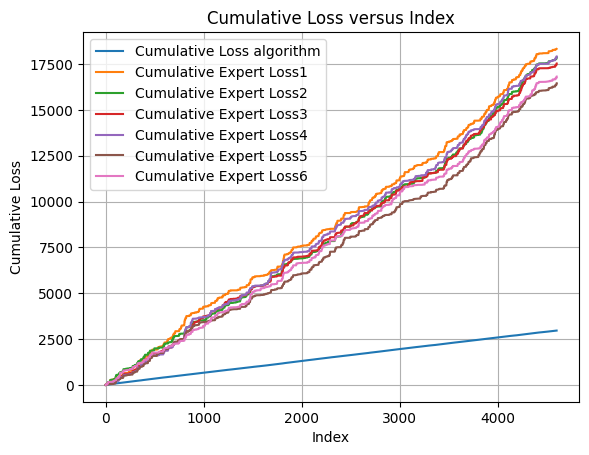

In [ ]:
import matplotlib.pyplot as plt

# Create a list of index values corresponding to the length of cumLossAlgo_plot
indices = list(range(len(cumLossAlgo_plot)))

# Plot cumLossAlgo_plot versus its index value
plt.plot(indices, cumLossAlgo_plot, label='Cumulative Loss algorithm')
plt.plot(indices, cumExpertLoss_plot1, label='Cumulative Expert Loss1')  # Add the second plot
plt.plot(indices, cumExpertLoss_plot2, label='Cumulative Expert Loss2')  # Add the second plot
plt.plot(indices, cumExpertLoss_plot3, label='Cumulative Expert Loss3')  # Add the second plot
plt.plot(indices, cumExpertLoss_plot4, label='Cumulative Expert Loss4')  # Add the second plot
plt.plot(indices, cumExpertLoss_plot5, label='Cumulative Expert Loss5')  # Add the second plot
plt.plot(indices, cumExpertLoss_plot6, label='Cumulative Expert Loss6')  # Add the second plot
plt.xlabel('Index')
plt.ylabel('Cumulative Loss')
plt.title('Cumulative Loss versus Index')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
staticAlphaCumLoss_Algo = cumLossAlgo_plot[:]

In [ ]:
FixedAlphaCumLoss_Algo1 = cumLossAlgo_plot[:]

In [ ]:
FixedAlphaCumLoss_Algo2 = cumLossAlgo_plot[:]

In [ ]:
FixedAlphaCumLoss_Algo3 = cumLossAlgo_plot[:]

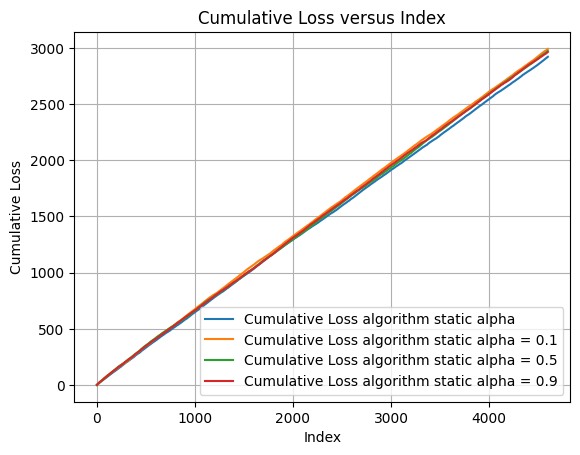

In [ ]:
# Create a list of index values corresponding to the length of cumLossAlgo_plot
indices = list(range(len(cumLossAlgo_plot)))

# Plot cumLossAlgo_plot versus its index value
plt.plot(indices, staticAlphaCumLoss_Algo, label='Cumulative Loss algorithm static alpha')
plt.plot(indices, FixedAlphaCumLoss_Algo1, label='Cumulative Loss algorithm static alpha = 0.1')  # Add the second plot
plt.plot(indices, FixedAlphaCumLoss_Algo2, label='Cumulative Loss algorithm static alpha = 0.5')  # Add the second plot
plt.plot(indices, FixedAlphaCumLoss_Algo3, label='Cumulative Loss algorithm static alpha = 0.9')  # Add the second plot

plt.xlabel('Index')
plt.ylabel('Cumulative Loss')
plt.title('Cumulative Loss versus Index')
plt.legend()
plt.grid(True)
plt.show()